In [1]:
import numpy as np
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt

# NST

- input: content image, style image
- output: generate image like (content + style) from noise image by using gradient descent

## References

- https://keras.io/examples/generative/neural_style_transfer/

# Load VGG-19 Model

In [2]:
# neural style transfer output

content_layers = ['block4_conv2']
style_layers = [
    'block1_conv1',
    'block2_conv1',
    'block3_conv1',
    'block4_conv1',
    'block5_conv1',
]

In [3]:
def load_vgg():
    vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
    # vgg.trainable = False
    
    # extracted feature
    layers = content_layers + style_layers
    outputs_dict = dict([(layer, vgg.get_layer(layer).output) for layer in layers])
    
    # model for nst
    feature_extractor = tf.keras.Model(inputs=vgg.input, outputs=outputs_dict)
    
    return feature_extractor

# Image Preprocessing

In [4]:
def preprocess_image(image_path, image_size=(500, 500)):
    """
        return: tensor type array. shape (1, height, width, channel).
    """
    
    
    img = tf.keras.preprocessing.image.load_img(
        image_path, target_size=image_size 
    )
    
    # image to numpy array shape (h, w, c)
    img = tf.keras.preprocessing.image.img_to_array(img)
    
    # to shape (1, h, w, c)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.vgg19.preprocess_input(img)
    
    return tf.convert_to_tensor(img)

In [5]:
def deprocess_image(tensor_img):
    img = np.array(tensor_img.numpy()[0], dtype=np.float64)
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    img = img[:, :, ::-1]
    img = np.clip(img, 0, 255).astype("uint8")

    return img

# Generated Image Tensor

In [6]:
def load_random_noise_tensor(img_tensor):
    random_noise = np.array(np.random.randint(0, 255, img_tensor.shape))
    gen_tensor = tf.Variable(random_noise, dtype=tf.float32)
    return gen_tensor

# Compute Loss

## Content loss

In [7]:
def compute_content_loss(content_feature, gen_feature, loss_weight=5e-6):
    return loss_weight*tf.reduce_sum(tf.square(content_feature - gen_feature))

## Style loss

In [8]:
def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

In [9]:
def compute_style_loss(style_feature, gen_feature, img_size, loss_weight=1e-6):
    S = gram_matrix(style_feature)
    G = gram_matrix(gen_feature)
    channels = 3
    size = img_size[0] * img_size[1]
    return loss_weight*tf.reduce_sum(tf.square(S - G))/(4.0*(channels**2)*(size**2))

## Total Variation loss

In [10]:
def compute_total_variation_loss(x, loss_weight=2e-6):
    img_nrows = x.shape[1]
    img_ncols = x.shape[2]
    a = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, 1:, : img_ncols - 1, :]
    )
    b = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, : img_nrows - 1, 1:, :]
    )
    return loss_weight*tf.reduce_sum(tf.pow(a + b, 1.25))

## Total Loss

In [11]:
def compute_total_loss(content_tensor, style_tensor, gen_tensor, content_layers, style_layers, img_size, a=0.8, b=0.2, c=0.1):
    input_tensor = tf.concat(
        [content_tensor, style_tensor, gen_tensor], axis=0
    )
    features = model(input_tensor)
    
    content_features = features[content_layers[0]]
    
    loss = tf.zeros(shape=())
    
    content_loss = compute_content_loss(content_features[0], content_features[2])
    loss += a*content_loss
    
    total_style_loss = tf.zeros(shape=())
    for layer in style_layers:
        layer_feature = features[layer]
        style_feature = layer_feature[1]
        gen_style_feature = layer_feature[2]
        layer_style_loss = compute_style_loss(style_feature, gen_style_feature, img_size)
        loss += (b/len(style_layers)) * layer_style_loss
        total_style_loss += (b/len(style_layers)) * layer_style_loss
    
    total_variation_loss = c*compute_total_variation_loss(gen_tensor)
    loss += total_variation_loss
    
    return loss, content_loss, total_style_loss, total_variation_loss

# Gradient

In [12]:
@tf.function
def compute_loss_and_grads(content_image_tensor, style_image_tensor, gen_image_tensor, content_layers, style_layers, img_size, content_w, style_w, varloss_w):
    with tf.GradientTape() as tape:
        loss, content_loss, total_style_loss, total_variation_loss = compute_total_loss(content_image_tensor, style_image_tensor, gen_image_tensor, 
                                                                  content_layers, style_layers, img_size, content_w, style_w, varloss_w)
    grads = tape.gradient(loss, gen_image_tensor)
    return loss, content_loss, total_style_loss, total_variation_loss, grads

# Training Function

In [13]:
def training_loop(content_tensor, style_tensor, gen_tensor, content_layers, style_layers, img_size, optimizer, content_w=0.8, style_w=0.1, varloss_w=0.1, max_iterations=10000):
    for i in range(1, max_iterations+1):
        if (i % 500 == 0) or (i == 1) or (i == max_iterations):
            loss, content_loss, total_style_loss, total_variation_loss, grads = compute_loss_and_grads(content_tensor, style_tensor, gen_tensor, 
                                                                                 content_layers, style_layers, img_size, content_w, style_w, varloss_w)
            optimizer.apply_gradients([(grads, gen_tensor)])
            print(f"iteration {i:8}, loss {loss:.2f}, content loss {content_loss:.2f}, style loss {total_style_loss:.2f}, total variation loss {total_variation_loss:.2f}")
            
        # show image
        if (i % 2000 == 0) or (i == 1) or (i == max_iterations):
            fig = plt.figure(figsize=(5, 5))
            plt.title(f"iteration {i}")
            plt.imshow(deprocess_image(gen_tensor))
            plt.show()
        
        # save image
        if (i % 1000 == 0) or (i == 1) or (i == max_iterations):
            save_img_arr = deprocess_image(gen_tensor)
            tf.keras.preprocessing.image.save_img(f"./nst_output_img/{i}.jpg", save_img_arr)
    
    fig = plt.figure(figsize=(5, 5))
    plt.title("final result")
    plt.imshow(deprocess_image(gen_tensor))
    plt.show()

# ---
# Train Model
# ---

## Configuration

In [14]:
# image
content_img_path = "./img/cityscape.jpg"
style_image_path = "./img/style_van_gogh.jpg"
resize_scale = 2.5

# optimizer
init_learning_rate = 100.0
decay_steps = 10000
decay_rate = 0.96

# iterations
training_iterations = 150000

# content and style weight
content_w = 0.7
style_w = 0.1
varloss_w = 0.2

# neural style transfer output
content_layers = ['block5_conv2']
style_layers = [
    'block1_conv1',
    'block2_conv1',
    'block3_conv1',
    'block4_conv1',
    'block5_conv1',
]

## Load Model and Optimizer

In [15]:
model = load_vgg()

optimizer = tf.keras.optimizers.Adam(
    tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=init_learning_rate, decay_steps=decay_steps, decay_rate=decay_rate
    )
)

## Load Image

In [16]:
# get image size
pil_im = Image.open(content_img_path)
pil_im_size = np.array(pil_im.size)
pil_im_resize = pil_im_size//resize_scale

# resized image size
img_size = (int(pil_im_resize[1]), int(pil_im_resize[0]))

# base image/target image tensor
content_img_tensor = preprocess_image(content_img_path, img_size)
style_img_tensor = preprocess_image(style_image_path, img_size)

# random image
gen_tensor = load_random_noise_tensor(content_img_tensor)

## Train ...

iteration        1, loss 219416.44, content loss 17510.78, style loss 50365.77, total variation loss 156793.12


iteration      500, loss 504798.00, content loss 18927.10, style loss 303258.09, total variation loss 188290.94
iteration     1000, loss 598291.94, content loss 21685.58, style loss 335110.16, total variation loss 248001.81
iteration     1500, loss 683528.00, content loss 20877.43, style loss 407211.78, total variation loss 261702.05
iteration     2000, loss 571335.88, content loss 22314.60, style loss 300288.34, total variation loss 255427.33


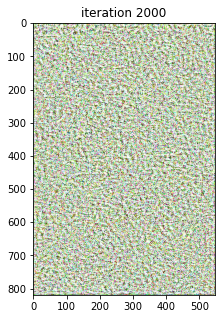

iteration     2500, loss 448717.94, content loss 19102.32, style loss 205311.17, total variation loss 230035.19
iteration     3000, loss 410998.91, content loss 18891.01, style loss 195834.80, total variation loss 201940.36
iteration     3500, loss 338464.16, content loss 18857.47, style loss 149804.89, total variation loss 175459.03
iteration     4000, loss 278118.03, content loss 18558.41, style loss 111366.74, total variation loss 153760.39


iteration     4500, loss 233310.55, content loss 17837.14, style loss 83368.41, total variation loss 137456.14
iteration     5000, loss 204419.88, content loss 17398.49, style loss 66668.30, total variation loss 125572.64
iteration     5500, loss 181856.11, content loss 17188.10, style loss 53454.55, total variation loss 116369.89
iteration     6000, loss 163738.53, content loss 16958.86, style loss 43402.25, total variation loss 108465.08


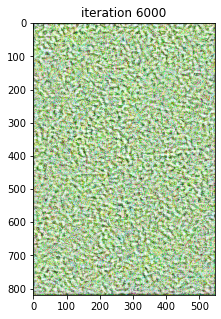

iteration     6500, loss 148497.83, content loss 16632.29, style loss 35840.32, total variation loss 101014.91
iteration     7000, loss 135279.58, content loss 16347.90, style loss 30182.44, total variation loss 93653.62
iteration     7500, loss 123195.59, content loss 16074.16, style loss 25620.77, total variation loss 86322.91
iteration     8000, loss 111951.46, content loss 15779.81, style loss 21761.14, total variation loss 79144.45


iteration     8500, loss 101595.15, content loss 15442.35, style loss 18498.55, total variation loss 72286.95
iteration     9000, loss 92183.41, content loss 15056.86, style loss 15763.88, total variation loss 65879.73
iteration     9500, loss 83738.43, content loss 14640.90, style loss 13505.45, total variation loss 59984.35
iteration    10000, loss 76168.36, content loss 14217.19, style loss 11623.97, total variation loss 54592.35


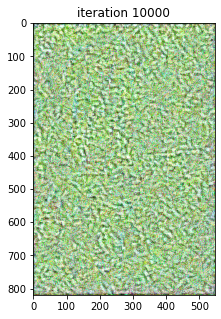

iteration    10500, loss 69353.59, content loss 13784.29, style loss 10047.02, total variation loss 49657.56
iteration    11000, loss 63191.54, content loss 13322.47, style loss 8739.23, total variation loss 45126.58
iteration    11500, loss 57600.18, content loss 12813.52, style loss 7668.19, total variation loss 40962.52
iteration    12000, loss 52543.56, content loss 12274.11, style loss 6803.03, total variation loss 37148.65


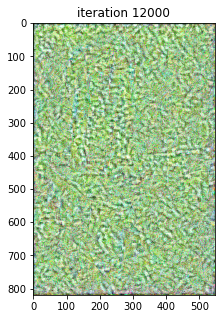

iteration    12500, loss 48012.17, content loss 11777.07, style loss 6088.86, total variation loss 33679.36
iteration    13000, loss 43939.92, content loss 11281.27, style loss 5493.52, total variation loss 30549.51
iteration    13500, loss 40298.09, content loss 10807.90, style loss 4983.89, total variation loss 27748.67
iteration    14000, loss 37017.76, content loss 10301.23, style loss 4549.49, total variation loss 25257.41


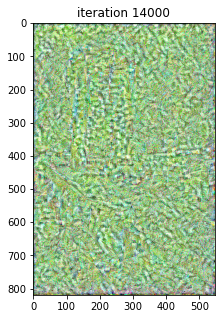

iteration    14500, loss 34080.01, content loss 9784.06, style loss 4185.02, total variation loss 23046.15
iteration    15000, loss 31459.84, content loss 9283.53, style loss 3879.67, total variation loss 21081.70
iteration    15500, loss 29124.12, content loss 8819.52, style loss 3623.07, total variation loss 19327.38
iteration    16000, loss 27002.79, content loss 8362.70, style loss 3400.96, total variation loss 17747.95


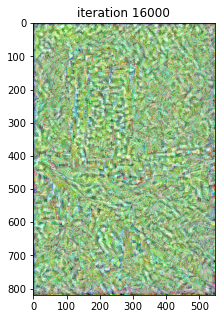

iteration    16500, loss 25095.02, content loss 7948.62, style loss 3213.12, total variation loss 16317.86
iteration    17000, loss 23360.92, content loss 7543.70, style loss 3059.82, total variation loss 15020.52
iteration    17500, loss 21778.46, content loss 7154.27, style loss 2928.24, total variation loss 13842.24
iteration    18000, loss 20350.26, content loss 6807.81, style loss 2813.31, total variation loss 12771.49


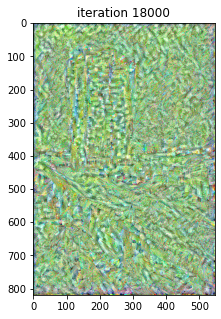

iteration    18500, loss 19043.18, content loss 6475.95, style loss 2710.43, total variation loss 11799.58
iteration    19000, loss 17861.38, content loss 6180.10, style loss 2617.63, total variation loss 10917.68
iteration    19500, loss 16790.22, content loss 5901.85, style loss 2540.47, total variation loss 10118.46
iteration    20000, loss 15804.63, content loss 5628.58, style loss 2468.77, total variation loss 9395.85


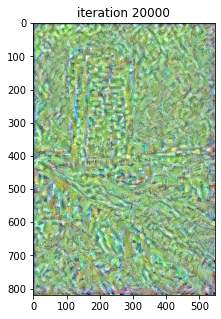

iteration    20500, loss 14917.72, content loss 5390.42, style loss 2402.64, total variation loss 8741.79
iteration    21000, loss 14117.92, content loss 5176.62, style loss 2344.23, total variation loss 8150.06
iteration    21500, loss 13376.16, content loss 4963.24, style loss 2288.06, total variation loss 7613.83
iteration    22000, loss 12723.58, content loss 4797.54, style loss 2238.51, total variation loss 7126.79


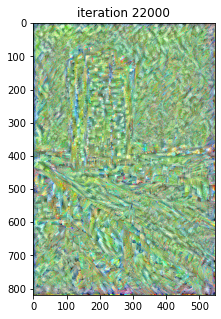

iteration    22500, loss 12092.24, content loss 4599.29, style loss 2191.27, total variation loss 6681.46
iteration    23000, loss 11549.77, content loss 4470.14, style loss 2145.44, total variation loss 6275.23
iteration    23500, loss 11016.34, content loss 4298.35, style loss 2100.65, total variation loss 5906.84
iteration    24000, loss 10558.76, content loss 4186.96, style loss 2056.75, total variation loss 5571.13


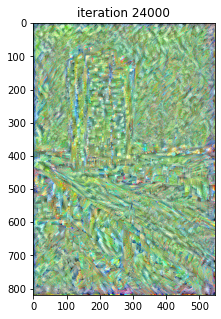

iteration    24500, loss 10124.16, content loss 4047.71, style loss 2022.94, total variation loss 5267.82
iteration    25000, loss 9729.97, content loss 3933.57, style loss 1982.21, total variation loss 4994.26
iteration    25500, loss 9342.20, content loss 3782.89, style loss 1945.48, total variation loss 4748.70
iteration    26000, loss 9048.06, content loss 3734.53, style loss 1907.31, total variation loss 4526.58


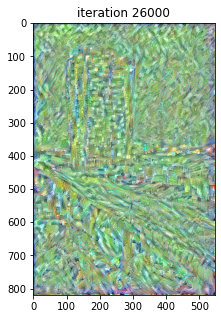

iteration    26500, loss 8729.83, content loss 3611.53, style loss 1873.47, total variation loss 4328.28
iteration    27000, loss 8499.97, content loss 3595.42, style loss 1839.61, total variation loss 4143.56
iteration    27500, loss 8221.53, content loss 3478.80, style loss 1807.46, total variation loss 3978.91
iteration    28000, loss 7973.79, content loss 3376.81, style loss 1778.39, total variation loss 3831.63


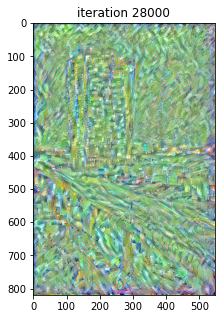

iteration    28500, loss 7765.41, content loss 3315.53, style loss 1747.40, total variation loss 3697.14
iteration    29000, loss 7569.69, content loss 3249.14, style loss 1721.26, total variation loss 3574.03
iteration    29500, loss 7394.75, content loss 3201.21, style loss 1692.23, total variation loss 3461.67
iteration    30000, loss 7250.38, content loss 3184.83, style loss 1663.69, total variation loss 3357.31


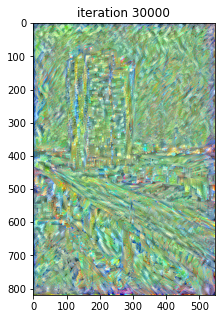

iteration    30500, loss 7113.89, content loss 3148.64, style loss 1640.95, total variation loss 3268.89
iteration    31000, loss 6979.24, content loss 3124.07, style loss 1608.68, total variation loss 3183.72
iteration    31500, loss 6839.03, content loss 3055.79, style loss 1590.10, total variation loss 3109.88
iteration    32000, loss 6771.54, content loss 3091.84, style loss 1559.91, total variation loss 3047.34


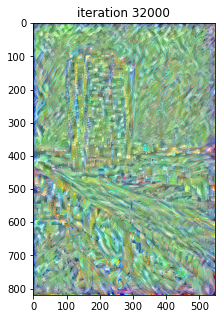

iteration    32500, loss 6626.06, content loss 3003.84, style loss 1535.52, total variation loss 2987.86
iteration    33000, loss 6519.63, content loss 2939.96, style loss 1524.99, total variation loss 2936.67
iteration    33500, loss 6433.63, content loss 2918.33, style loss 1500.36, total variation loss 2890.44
iteration    34000, loss 6346.14, content loss 2882.05, style loss 1479.23, total variation loss 2849.47


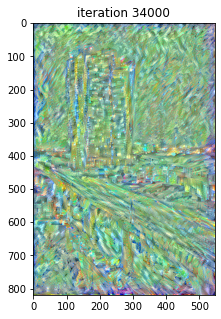

iteration    34500, loss 6220.28, content loss 2785.23, style loss 1459.71, total variation loss 2810.91
iteration    35000, loss 6202.52, content loss 2835.80, style loss 1445.04, total variation loss 2772.42
iteration    35500, loss 6144.26, content loss 2817.96, style loss 1433.79, total variation loss 2737.90
iteration    36000, loss 6124.56, content loss 2861.74, style loss 1415.63, total variation loss 2705.71


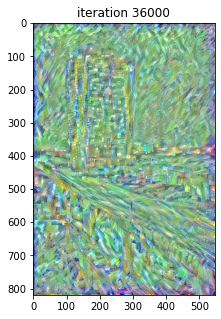

iteration    36500, loss 6032.31, content loss 2789.26, style loss 1399.40, total variation loss 2680.43
iteration    37000, loss 6006.71, content loss 2800.13, style loss 1382.71, total variation loss 2663.90
iteration    37500, loss 5910.34, content loss 2703.30, style loss 1370.56, total variation loss 2647.47
iteration    38000, loss 5928.29, content loss 2767.25, style loss 1358.12, total variation loss 2633.09


iteration    38500, loss 5892.66, content loss 2754.44, style loss 1343.12, total variation loss 2621.43
iteration    39000, loss 5871.55, content loss 2755.57, style loss 1335.23, total variation loss 2607.42
iteration    39500, loss 5879.40, content loss 2789.83, style loss 1323.88, total variation loss 2602.64
iteration    40000, loss 5834.04, content loss 2740.34, style loss 1316.81, total variation loss 2598.99


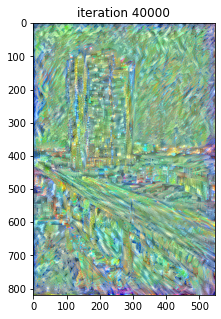

iteration    40500, loss 5815.58, content loss 2733.47, style loss 1297.16, total variation loss 2605.00
iteration    41000, loss 5743.18, content loss 2643.48, style loss 1285.89, total variation loss 2606.85
iteration    41500, loss 5719.84, content loss 2629.69, style loss 1273.94, total variation loss 2605.11
iteration    42000, loss 5737.42, content loss 2677.21, style loss 1265.94, total variation loss 2597.44


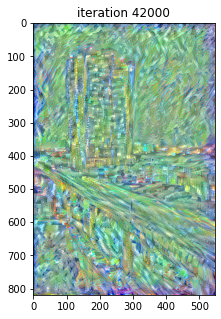

iteration    42500, loss 5764.15, content loss 2752.63, style loss 1246.88, total variation loss 2590.43
iteration    43000, loss 5744.03, content loss 2745.05, style loss 1236.21, total variation loss 2586.28
iteration    43500, loss 5715.94, content loss 2711.95, style loss 1227.92, total variation loss 2589.66
iteration    44000, loss 5720.53, content loss 2717.88, style loss 1224.35, total variation loss 2593.66


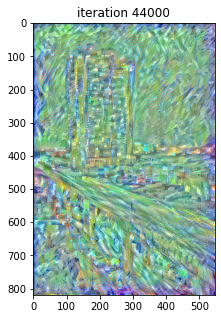

iteration    44500, loss 5631.73, content loss 2595.21, style loss 1208.23, total variation loss 2606.85
iteration    45000, loss 5652.29, content loss 2625.30, style loss 1201.85, total variation loss 2612.73
iteration    45500, loss 5632.02, content loss 2605.18, style loss 1195.35, total variation loss 2613.04
iteration    46000, loss 5617.95, content loss 2610.12, style loss 1187.22, total variation loss 2603.65


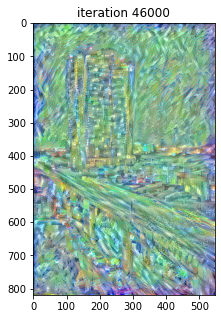

iteration    46500, loss 5611.17, content loss 2610.62, style loss 1187.60, total variation loss 2596.13
iteration    47000, loss 5675.34, content loss 2735.44, style loss 1177.93, total variation loss 2582.60
iteration    47500, loss 5609.97, content loss 2642.10, style loss 1175.88, total variation loss 2584.62
iteration    48000, loss 5658.62, content loss 2727.31, style loss 1163.80, total variation loss 2585.71


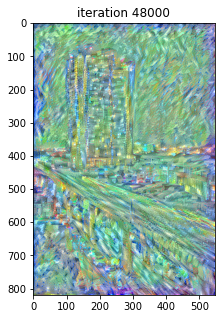

iteration    48500, loss 5613.07, content loss 2646.23, style loss 1153.37, total variation loss 2607.35
iteration    49000, loss 5683.03, content loss 2732.30, style loss 1141.32, total variation loss 2629.10
iteration    49500, loss 5726.41, content loss 2779.26, style loss 1128.52, total variation loss 2652.40
iteration    50000, loss 5712.99, content loss 2738.44, style loss 1126.49, total variation loss 2669.60


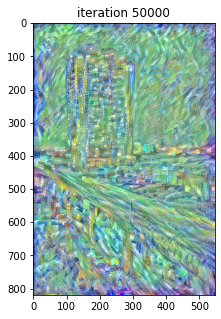

iteration    50500, loss 5692.42, content loss 2690.62, style loss 1114.65, total variation loss 2694.34
iteration    51000, loss 5656.38, content loss 2639.40, style loss 1103.16, total variation loss 2705.64
iteration    51500, loss 5583.83, content loss 2525.27, style loss 1104.27, total variation loss 2711.87
iteration    52000, loss 5660.01, content loss 2655.67, style loss 1103.50, total variation loss 2697.54


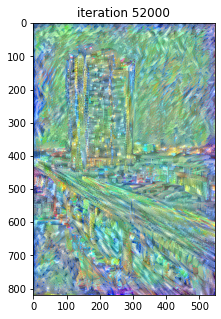

iteration    52500, loss 5614.46, content loss 2597.63, style loss 1101.24, total variation loss 2694.87
iteration    53000, loss 5733.15, content loss 2814.66, style loss 1090.41, total variation loss 2672.49
iteration    53500, loss 5656.69, content loss 2704.55, style loss 1091.34, total variation loss 2672.17
iteration    54000, loss 5745.15, content loss 2854.70, style loss 1081.85, total variation loss 2665.01


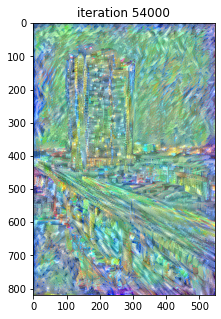

iteration    54500, loss 5655.21, content loss 2701.91, style loss 1077.90, total variation loss 2685.98
iteration    55000, loss 5779.34, content loss 2868.71, style loss 1067.99, total variation loss 2703.26
iteration    55500, loss 5723.01, content loss 2749.00, style loss 1057.16, total variation loss 2741.55
iteration    56000, loss 5907.36, content loss 2998.99, style loss 1041.80, total variation loss 2766.27


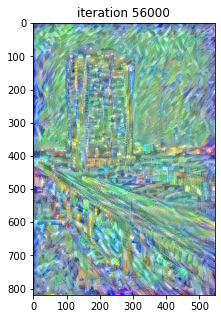

iteration    56500, loss 5809.39, content loss 2794.38, style loss 1041.09, total variation loss 2812.23
iteration    57000, loss 6009.56, content loss 3053.34, style loss 1025.90, total variation loss 2846.32
iteration    57500, loss 5935.53, content loss 2871.52, style loss 1028.03, total variation loss 2897.43
iteration    58000, loss 6093.55, content loss 3075.35, style loss 1010.98, total variation loss 2929.82


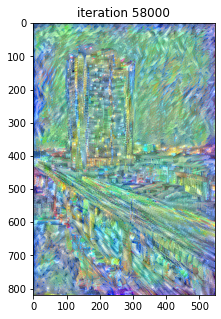

iteration    58500, loss 6010.50, content loss 2884.00, style loss 1005.65, total variation loss 2986.05
iteration    59000, loss 6140.70, content loss 3046.62, style loss 993.53, total variation loss 3014.54
iteration    59500, loss 5986.29, content loss 2781.85, style loss 991.95, total variation loss 3047.04
iteration    60000, loss 6014.86, content loss 2830.40, style loss 986.90, total variation loss 3046.67


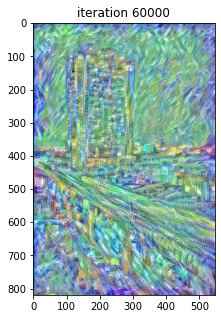

iteration    60500, loss 5898.32, content loss 2680.07, style loss 984.85, total variation loss 3037.42
iteration    61000, loss 5916.71, content loss 2751.65, style loss 988.89, total variation loss 3001.67
iteration    61500, loss 5828.04, content loss 2681.71, style loss 984.13, total variation loss 2966.70
iteration    62000, loss 5837.65, content loss 2752.25, style loss 987.96, total variation loss 2923.11


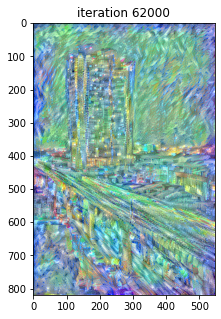

iteration    62500, loss 5719.09, content loss 2638.64, style loss 979.60, total variation loss 2892.44
iteration    63000, loss 5753.42, content loss 2742.31, style loss 979.66, total variation loss 2854.15
iteration    63500, loss 5725.34, content loss 2719.90, style loss 983.03, total variation loss 2838.38
iteration    64000, loss 5740.67, content loss 2774.30, style loss 975.89, total variation loss 2822.77


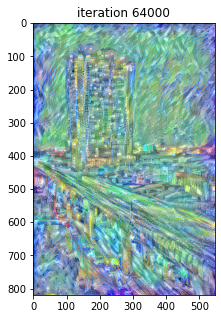

iteration    64500, loss 5748.35, content loss 2790.95, style loss 976.60, total variation loss 2818.08
iteration    65000, loss 5826.45, content loss 2915.96, style loss 966.66, total variation loss 2818.63
iteration    65500, loss 5785.88, content loss 2853.55, style loss 950.81, total variation loss 2837.58
iteration    66000, loss 5866.99, content loss 2940.98, style loss 964.12, total variation loss 2844.17


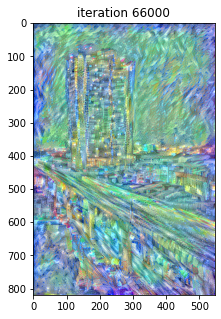

iteration    66500, loss 5806.36, content loss 2837.84, style loss 940.31, total variation loss 2879.57
iteration    67000, loss 5989.88, content loss 3062.45, style loss 943.60, total variation loss 2902.57
iteration    67500, loss 5974.27, content loss 2991.72, style loss 923.26, total variation loss 2956.81
iteration    68000, loss 6188.56, content loss 3217.26, style loss 933.04, total variation loss 3003.44


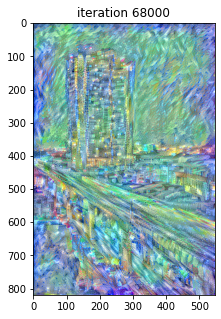

iteration    68500, loss 6108.10, content loss 3017.12, style loss 911.57, total variation loss 3084.54
iteration    69000, loss 6275.96, content loss 3171.34, style loss 902.40, total variation loss 3153.62
iteration    69500, loss 6304.65, content loss 3110.61, style loss 902.48, total variation loss 3224.75
iteration    70000, loss 6394.90, content loss 3188.97, style loss 896.36, total variation loss 3266.26


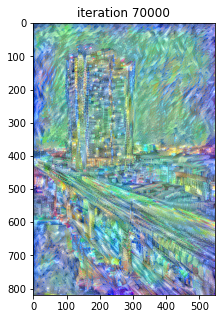

iteration    70500, loss 6296.47, content loss 2984.39, style loss 895.64, total variation loss 3311.76
iteration    71000, loss 6515.94, content loss 3296.07, style loss 888.17, total variation loss 3320.53
iteration    71500, loss 6320.31, content loss 2988.88, style loss 889.43, total variation loss 3338.67
iteration    72000, loss 6476.67, content loss 3234.33, style loss 877.83, total variation loss 3334.80


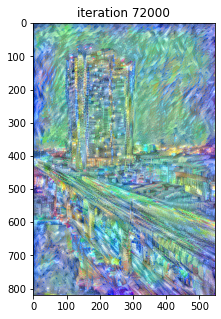

iteration    72500, loss 6398.00, content loss 3101.60, style loss 882.91, total variation loss 3343.97
iteration    73000, loss 6496.85, content loss 3250.82, style loss 881.21, total variation loss 3340.08
iteration    73500, loss 6419.39, content loss 3109.34, style loss 888.07, total variation loss 3354.78
iteration    74000, loss 6537.05, content loss 3290.59, style loss 876.73, total variation loss 3356.90


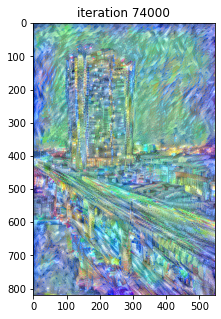

iteration    74500, loss 6411.33, content loss 3089.24, style loss 868.14, total variation loss 3380.73
iteration    75000, loss 6550.16, content loss 3285.36, style loss 857.57, total variation loss 3392.84
iteration    75500, loss 6479.55, content loss 3167.80, style loss 856.09, total variation loss 3406.00
iteration    76000, loss 6477.18, content loss 3129.80, style loss 859.95, total variation loss 3426.37


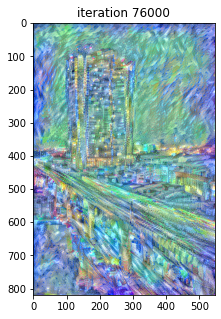

iteration    76500, loss 6441.83, content loss 3087.40, style loss 850.91, total variation loss 3429.73
iteration    77000, loss 6423.08, content loss 3045.68, style loss 851.85, total variation loss 3439.26
iteration    77500, loss 6557.28, content loss 3260.64, style loss 855.07, total variation loss 3419.76
iteration    78000, loss 6471.07, content loss 3156.14, style loss 850.13, total variation loss 3411.64


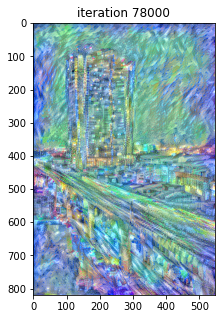

iteration    78500, loss 6531.33, content loss 3274.38, style loss 849.67, total variation loss 3389.60
iteration    79000, loss 6396.25, content loss 3093.51, style loss 838.82, total variation loss 3391.97
iteration    79500, loss 6386.10, content loss 3076.82, style loss 840.44, total variation loss 3391.89
iteration    80000, loss 6417.66, content loss 3123.39, style loss 832.70, total variation loss 3398.59


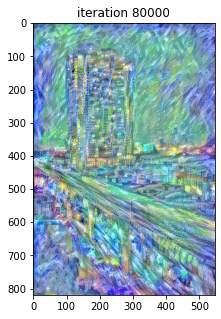

iteration    80500, loss 6524.98, content loss 3271.00, style loss 848.56, total variation loss 3386.71
iteration    81000, loss 6526.32, content loss 3275.15, style loss 828.49, total variation loss 3405.22
iteration    81500, loss 6603.21, content loss 3350.97, style loss 841.39, total variation loss 3416.14
iteration    82000, loss 6592.50, content loss 3282.64, style loss 831.38, total variation loss 3463.27


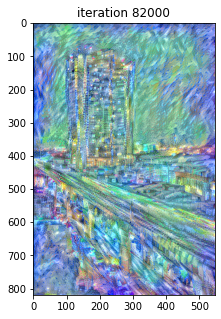

iteration    82500, loss 6660.65, content loss 3323.25, style loss 838.81, total variation loss 3495.56
iteration    83000, loss 6787.23, content loss 3449.59, style loss 820.81, total variation loss 3551.70
iteration    83500, loss 6780.98, content loss 3387.39, style loss 839.07, total variation loss 3570.73
iteration    84000, loss 6583.91, content loss 3079.08, style loss 819.77, total variation loss 3608.78


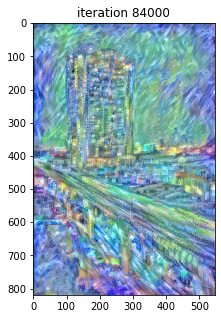

iteration    84500, loss 6689.66, content loss 3215.68, style loss 823.90, total variation loss 3614.79
iteration    85000, loss 6621.14, content loss 3132.08, style loss 819.68, total variation loss 3609.01
iteration    85500, loss 6695.88, content loss 3277.84, style loss 816.66, total variation loss 3584.73
iteration    86000, loss 6669.24, content loss 3262.63, style loss 815.29, total variation loss 3570.10


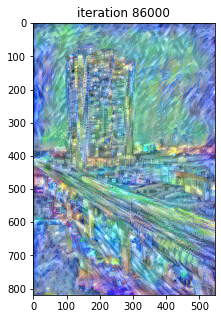

iteration    86500, loss 6832.37, content loss 3519.35, style loss 823.19, total variation loss 3545.64
iteration    87000, loss 6696.38, content loss 3320.80, style loss 805.97, total variation loss 3565.85
iteration    87500, loss 6749.44, content loss 3357.18, style loss 815.85, total variation loss 3583.56
iteration    88000, loss 6780.95, content loss 3367.05, style loss 790.93, total variation loss 3633.08


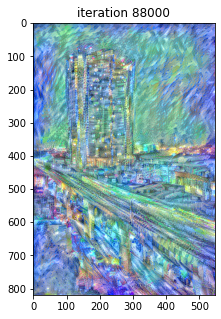

iteration    88500, loss 7004.53, content loss 3611.68, style loss 822.26, total variation loss 3654.10
iteration    89000, loss 6930.87, content loss 3470.57, style loss 792.72, total variation loss 3708.75
iteration    89500, loss 7047.02, content loss 3580.05, style loss 798.08, total variation loss 3742.91
iteration    90000, loss 6976.45, content loss 3407.75, style loss 786.23, total variation loss 3804.79


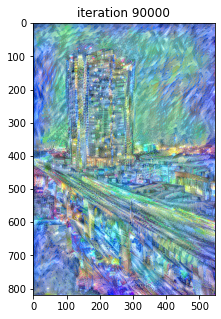

iteration    90500, loss 7204.53, content loss 3665.09, style loss 800.47, total variation loss 3838.49


In [ ]:
training_loop(content_img_tensor, style_img_tensor, gen_tensor, 
              content_layers, style_layers, img_size, optimizer, 
              content_w, style_w, varloss_w, training_iterations)

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(21, 7))
axs[0].imshow(deprocess_image(content_img_tensor))
axs[0].set_title("Content")
axs[0].axis('off')
axs[1].imshow(deprocess_image(style_img_tensor))
axs[1].set_title("Style")
axs[1].axis('off')
axs[2].imshow(deprocess_image(gen_tensor))
axs[2].set_title("Combination")
plt.axis('off')
plt.savefig("./nst.jpg", dpi=150)
plt.show()

##### 